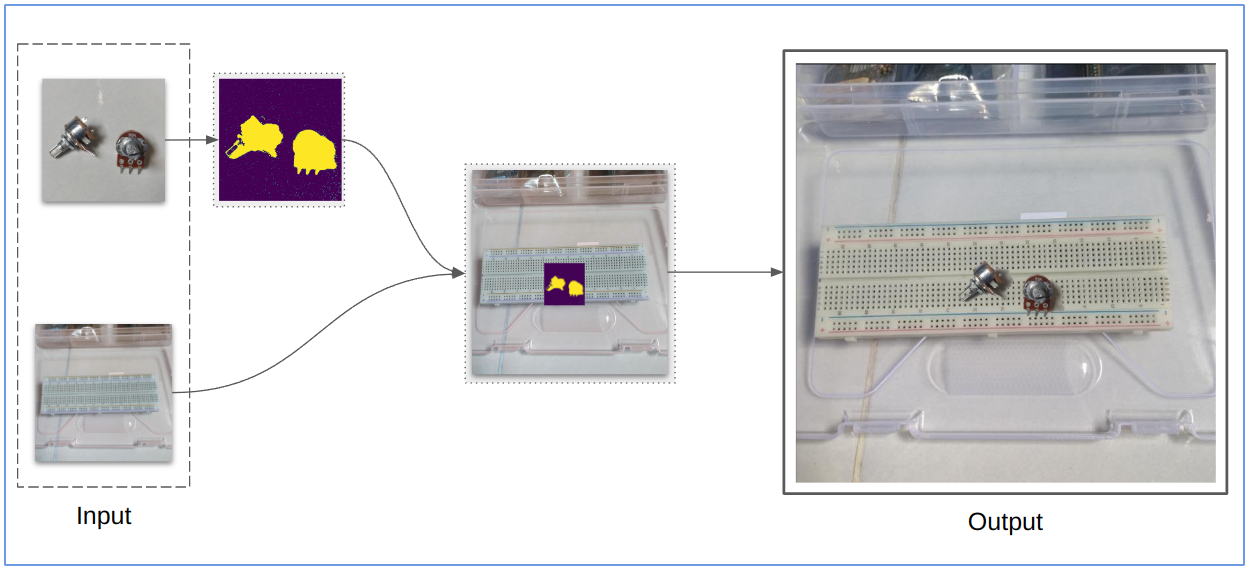

In [ ]:
!pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="4RUTyrOepjc6i9IotpFM")
project = rf.workspace("fa23ai02-objdetection-2").project("trainable-iot")
dataset = project.version(7).download("yolov5")


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Segment small objects

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pickle
import random

In [4]:
import os
from datetime import datetime
import pytz


In [5]:
# @title def create_mask
def create_mask(s_img, thresh_mean_ratio: float, size_desired=(640,640)):
  '''Create a mask of segmented object from `s_img_file`
        . thresh_mean_ratio: a float between [0, 1], the higher value will lead to
            the more object(and noise) to be captured.
        '''
  def _filter_cnt(contours):
    wmin, wmax = 10, 600  # bbox size
    hmin, hmax = 10, 600
    border = 600
    contours_new = []
    for cnt in contours:
        rect = cv2.minAreaRect(cnt)
        width = rect[1][0]
        height = rect[1][1]
        # print(rect)
        center_x, center_y = rect[0]
        # print(center_x, center_y)
        if (center_x > border or center_y > border):
          continue
        if (width>wmax) or (height >hmax) or (width < wmin) or (height < hmin):
          continue
        contours_new.append(cnt)
    return contours_new

  img = cv2.cvtColor(s_img,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,size_desired)
  gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
  gray = cv2.GaussianBlur(gray, (3,3), 0) # blur for better segmentation

  # Divide into 2 colors by THRESH
  _,thresh = cv2.threshold(gray, thresh=np.mean(gray)*thresh_mean_ratio,
                           maxval=255, type=cv2.THRESH_TOZERO_INV)  #THRESH_BINARY_INV)

  # Detect contours
  contours, hierarchy = cv2.findContours(image=thresh, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_NONE)
  contours_filtered = _filter_cnt(contours)

  # Create a mask from contours
  mask = np.zeros(size_desired, np.uint8)
  mask = cv2.drawContours(mask, contours, -1, 1, cv2.FILLED) # mask, contours, idx, color, paint_type

  # Apply mask onto s_img
  mask_3d = np.stack((mask, mask, mask), axis=-1)
  img_copy = img.copy()
  img_masked = cv2.multiply(img_copy, mask_3d)

  return mask, thresh, img_masked

In [6]:
# @title def overlay_image
def overlay_image_alpha(bg_img, s_img, s_img_mask, location_xy, overlay_size):
    """Overlay `s_img` onto `bg_img` at (x, y). """
    x, y = location_xy
    def _resize(img, overlay_size_hw):
      img = cv2.resize(img, overlay_size_hw,
                interpolation = cv2.INTER_AREA)
      return img

    # Resize s_img and its mask
    s_img = _resize(s_img, overlay_size)
    s_img_mask = _resize(s_img_mask, overlay_size)
    h_new, w_new = s_img.shape[:2]
    print('s_img resized to shape: ', overlay_size)
    print(' placing at location (x, y) =', location_xy)

    # Return if s_img exceed the bg_image's border
    h_bg, w_bg = bg_img.shape[:2]
    if h_new + x > h_bg or w_new + y > w_bg:
      print('s_img exceed bg_img border. Return bg_img only.')
      return bg_img

    # Combine 2 images
    mask_inv = 1 - s_img_mask
    x2 = x + h_new
    y2 = y + w_new
    cb_img = bg_img.copy() # combined image
    for c in range(0, 3):
      cb_img[y:y2, x:x2, c] = (s_img_mask * s_img[:, :, c] +
                                  mask_inv * bg_img[y:y2, x:x2, c])
    return cb_img


In [7]:
# @title def overlay_obj_labels [backup]
def overlay_obj_labels(bg_img, bg_label, s_img, s_label, mask, size_small_obj, num_small_obj,):
    # location: random inside bbox of bg_obj --> produce 10 images

    def _rresize(image, new_size_hw):
      image = cv2.resize(image, new_size_hw,
                interpolation = cv2.INTER_AREA)
      return image

    # turn xywh into x1x2y1y2
    def get_bg_obj(bg_img, bg_label):
      with open(bg_label, 'r') as f:
        bg_label_content = f.read().split('\n') #['0 0.475 0.5078125 0.8703125 0.31875', ...]
      firstbbox = bg_label_content[0].split()

      # turn into x, y, x2, y2
      center_x_ratio, center_y_ratio, w_ratio, h_ratio = [float(i) for i in firstbbox[1:5]]
      x1, x2 = [int(w_bg_img*x_i) for x_i in (center_x_ratio-w_ratio/2, center_x_ratio+w_ratio/2)]
      y1, y2 = [int(h_bg_img*y_i) for y_i in (center_y_ratio-h_ratio/2, center_y_ratio+h_ratio/2)]
      return x1, y1, x2, y2, bg_label_content

    def process_label_small_image(s_img, s_img_label, size_new, location_on_bg_xy,
                              bg_img_size = (640, 640)):
      with open(s_img_label, 'r') as f:
        s_label_content = f.read().split('\n') #['0 0.475 0.5078125 0.8703125 0.31875', ...]

      shrink_ratio = float(size_new[0])/s_img.shape[0] # 0.4 or something
      # print('shrink_ratio ', shrink_ratio)
      label_content_new = []
      for bbox_str in s_label_content:
        bbox_list = bbox_str.split()
        x_ratio, y_ratio, w, h = [float(i) for i in bbox_list[1:5]]
        w_new = w*shrink_ratio
        h_new = h*shrink_ratio
        x = x_ratio*w
        y = y_ratio*h
        loc_x, loc_y = location_on_bg_xy
        x_new = int(x*shrink_ratio) + loc_x
        y_new = int(y*shrink_ratio) + loc_y
        bbox_list[1] = x_ratio_new = str(x_new/bg_img_size[0])
        bbox_list[2] = y_ratio_new = str(y_new/bg_img_size[1])
        bbox_list[3] = str(w_new)
        bbox_list[4] = str(h_new)
        bbox_str_new = ' '.join(bbox_list)
        label_content_new.append(bbox_str_new)

      return label_content_new # list of strings

    s_img = _rresize(s_img, size_small_obj)

    h_bg_img, w_bg_img = bg_img.shape[:2]
    h_s_img, w_s_img = s_img.shape[:2]

    x1, y1, x2, y2, bg_obj_labels = get_bg_obj(bg_img, bg_label)

    # return if new_size is too big
    if (x1> x2-w_s_img) or (y1 > y2-h_s_img):
      print('s_obj is too big, cannot overlay')
      return None, None
    # random location x, y
    location_x = random.randint(x1, x2-w_s_img)
    location_y = random.randint(y1, y2-h_s_img)
    location_xy = (location_x, location_y)
    img_combined = overlay_image_alpha(bg_img, s_img, mask, location_xy=location_xy, overlay_size=size_small_obj)

    # Produce new label file
    small_obj_labels = process_label_small_image(s_img, s_label, size_small_obj, location_xy)
    all_obj_labels  = small_obj_labels + bg_obj_labels

    return img_combined, all_obj_labels



In [35]:
# @title def overlay_obj_labels [testing....]
def overlay_obj_labels(bg_img, bg_label, s_img, s_label, mask, size_small_obj, num_small_obj,):
    # location: random inside bbox of bg_obj --> produce 10 images

    def _rresize(image, new_size_hw):
      image = cv2.resize(image, new_size_hw,
                interpolation = cv2.INTER_AREA)
      return image

    # turn xywh into x1x2y1y2
    def get_bg_obj(bg_img, bg_label):
      with open(bg_label, 'r') as f:
        bg_label_content = f.read().split('\n') #['0 0.475 0.5078125 0.8703125 0.31875', ...]
      firstbbox = bg_label_content[0].split()

      # turn into x, y, x2, y2
      center_x_ratio, center_y_ratio, w_ratio, h_ratio = [float(i) for i in firstbbox[1:5]]
      x1, x2 = [int(w_bg_img*x_i) for x_i in (center_x_ratio-w_ratio/2, center_x_ratio+w_ratio/2)]
      y1, y2 = [int(h_bg_img*y_i) for y_i in (center_y_ratio-h_ratio/2, center_y_ratio+h_ratio/2)]
      return x1, y1, x2, y2, bg_label_content

    def process_label_small_image(s_img, s_img_label, size_new, location_on_bg_xy,
                              bg_img_size = (640, 640)):
      with open(s_img_label, 'r') as f:
        s_label_content = f.read().split('\n') #['0 0.475 0.5078125 0.8703125 0.31875', ...]

      shrink_ratio = float(size_new[0])/s_img.shape[0] # 0.4 or something
      # print('s_img shrinked to  ', size_new)
      # print('s_img placed at ', location_on_bg_xy)
      label_content_new = []
      for bbox_str in s_label_content:
        bbox_list = bbox_str.split()
        x_ratio, y_ratio, w, h = [float(i) for i in bbox_list[1:5]]
        w_new = w*s_img.shape[1]/bg_img_size[1]  #] shrink_ratio
        h_new = h*s_img.shape[0]/bg_img_size[0]            #shrink_ratio
        x = x_ratio*size_new[0]
        y = y_ratio*size_new[0]
        loc_x, loc_y = location_on_bg_xy
        x_new = int(x*shrink_ratio) + loc_x
        y_new = int(y*shrink_ratio) + loc_y
        bbox_list[1] = x_ratio_new = str(x_new/bg_img_size[0])
        bbox_list[2] = y_ratio_new = str(y_new/bg_img_size[1])
        bbox_list[3] = str(w_new)
        bbox_list[4] = str(h_new)
        bbox_str_new = ' '.join(bbox_list)
        label_content_new.append(bbox_str_new)
      return label_content_new # list of strings

    s_img = _rresize(s_img, size_small_obj)

    print('Background image\'s shape: ', bg_img.shape[:2])
    h_bg_img, w_bg_img = bg_img.shape[:2]
    h_s_img, w_s_img = s_img.shape[:2]

    x1, y1, x2, y2, bg_obj_labels = get_bg_obj(bg_img, bg_label)
    # x1_small, y1_small, x2_small, y2_small, _ = get_bg_obj(s_img, s_label)

    low_right_x = w_bg_img-w_s_img   # low_right of bg_img
    low_right_y = h_bg_img-h_s_img
    # low_right_x = x2 - w_s_img          # low_right of bg_obj bbox
    # low_right_y = y2 - h_s_img

    # return if new_size of s_img is too big
    if (x1> low_right_x) or (y1 > low_right_y):
      print('s_obj is too big, cannot overlay')
      return None, None
    # random location x, y
    location_x = random.randint(x1, low_right_x)
    location_y = random.randint(y1, low_right_y)
    location_xy = (location_x, location_y)
    img_combined = overlay_image_alpha(bg_img, s_img, mask, location_xy=location_xy, overlay_size=size_small_obj)

    # Produce new label file
    small_obj_labels = process_label_small_image(s_img, s_label, size_small_obj, location_xy)
    all_obj_labels  = small_obj_labels + bg_obj_labels
    print('num of objects in this img: ', len(all_obj_labels))

    img_combined = cv2.cvtColor(img_combined, cv2.COLOR_BGR2RGB)
    return img_combined, all_obj_labels



In [36]:
s_img_keypad = cv2.imread('/content/Trainable-IoT-7/train/images/1695976165733_jpg.rf.296ed1d79d38c2c54c411e8dd9a583a6.jpg')
s_img_keypad_lbl = '/content/Trainable-IoT-7/train/labels/1695976165733_jpg.rf.296ed1d79d38c2c54c411e8dd9a583a6.txt'
img_bread = cv2.imread('/content/Trainable-IoT-7/train/images/1695203528797_jpg.rf.507de957c04a60267632cce44dc279ff.jpg')
img_bread_lbl = '/content/Trainable-IoT-7/train/labels/1695203528797_jpg.rf.507de957c04a60267632cce44dc279ff.txt'

img_bread2 = cv2.imread('/content/drive/MyDrive/AI_Engineer/Dataset-IoT/segment-overlay-ready/images/segment_overlay_20231025_112442.jpg')
img_bread2_lbl = '/content/drive/MyDrive/AI_Engineer/Dataset-IoT/segment-overlay-ready/labels/segment_overlay_20231025_112442.txt'

# #################
s_img_potentio = cv2.imread('/content/Trainable-IoT-7/train/images/1695203528892_jpg.rf.aa721dccb1004f5a7abf2b8b9cb9462f.jpg')
s_img_potentio_label = '/content/Trainable-IoT-7/train/labels/1695203528892_jpg.rf.aa721dccb1004f5a7abf2b8b9cb9462f.txt'

img_lcd = cv2.imread('/content/Trainable-IoT-7/train/images/IMG_20230919_150755_jpg.rf.07b7a36750d44c3e8649e9660797eda0.jpg')
img_lcd_lbl = '/content/Trainable-IoT-7/train/labels/IMG_20230919_150755_jpg.rf.07b7a36750d44c3e8649e9660797eda0.txt'

img_rhe = cv2.imread('/content/Trainable-IoT-7/train/images/1695203528809_jpg.rf.0f420ff730f7dbd93d1d4c9a717b28ad.jpg')
img_rhe_lbl = '/content/Trainable-IoT-7/train/labels/1695203528809_jpg.rf.0f420ff730f7dbd93d1d4c9a717b28ad.txt'

img_buzz = cv2.imread('/content/Trainable-IoT-7/train/images/1695203528985_jpg.rf.421f4865f6ce8f01bc058fcaf3ae4689.jpg')
img_buzz_lbl = '/content/Trainable-IoT-7/train/labels/1695203528985_jpg.rf.421f4865f6ce8f01bc058fcaf3ae4689.txt'

img_usb = cv2.imread('/content/Trainable-IoT-7/train/images/1695203529053_jpg.rf.e7b780aa305efbb9932b7294d6b02639.jpg')
img_usb_lbl = '/content/Trainable-IoT-7/train/labels/1695203529053_jpg.rf.e7b780aa305efbb9932b7294d6b02639.txt'

Background image's shape:  (640, 640)
s_img resized to shape:  (200, 200)
 placing at location (x, y) = (140, 272)
num of objects in this img:  3


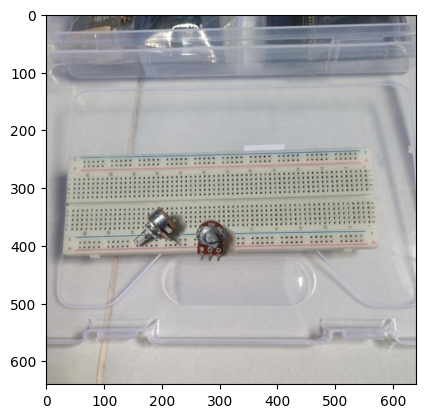

In [42]:
bg_img = img_bread
bg_label = img_bread_lbl
s_img = s_img_potentio
s_img_lbl = s_img_potentio_label
# ########################################################################### #
mask, thresh, img_masked = create_mask(s_img, 0.93)
img_combined2, all_obj_labels = overlay_obj_labels(bg_img, bg_label, s_img, s_img_lbl, mask, (200,200), 1)

if img_combined2 is not None:
  plt.imshow(img_combined2)

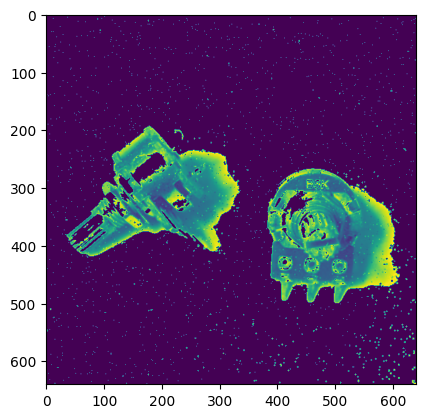

In [41]:
plt.imshow(thresh)

In [ ]:
# @title Save Image&Label
NEW_SEGMENT_OVERLAY = "/content/drive/MyDrive/AI_Engineer/Dataset-IoT/segment-overlay-ready" # @param {type:"string"}

def save_img_label(img_combined, all_obj_labels, NEW_SEGMENT_OVERLAY):
    datetime_str = datetime.now(pytz.timezone('Asia/Ho_Chi_Minh')).strftime("%Y%m%d_%H%M%S")
    img_label_filename = f'segment_overlay_{datetime_str}'

    label_filename = f'{NEW_SEGMENT_OVERLAY}/labels/{img_label_filename}.txt'
    img_filename = f'{NEW_SEGMENT_OVERLAY}/images/{img_label_filename}.jpg'
    with open(label_filename, 'w') as f:
      for bbox in all_obj_labels:
        f.write(f'{bbox}\n')

    cv2.imwrite(img_filename, img_combined)
    print("Image saved to ", img_filename)
    print("Label saved to ",label_filename)

save_img_label(img_combined2, all_obj_labels, NEW_SEGMENT_OVERLAY)

Image saved to  /content/drive/MyDrive/AI_Engineer/Dataset-IoT/segment-overlay-ready/images/segment_overlay_20231025_113441.jpg
Label saved to  /content/drive/MyDrive/AI_Engineer/Dataset-IoT/segment-overlay-ready/labels/segment_overlay_20231025_113441.txt


### test plot

In [32]:
# @title _process_img
data_yaml_path = "/content/Trainable-IoT-7/data.yaml"
import cv2, os, yaml
from PIL import Image
def _process_img(image_file:str, label_pred_file:str, label_true_file: str, max_img_size=(640, 640)):
   # '''Read image - Draw bbox - Save image'''


    # Read image
    img =cv2.imread(image_file)
    w,h = img.shape[:2]
    # get class mapping id-name
    with open(data_yaml_path, 'r') as f:
        data_info = yaml.load(f, Loader=yaml.loader.SafeLoader)
        classes = data_info['names']

    if label_true_file:# is not None:
        with open(label_true_file, 'r') as f:
            label_true = f.readlines()
    else:
        label_true = None

    # Get object(bbox) info from label file
    try:
      with open(label_pred_file, 'r') as f:
          label_content = f.readlines()
    except:
      # print('empty labels, ignore background image.')

      pass
    number_of_objects = int(len(label_true))
    # print('no of objects: ', number_of_objects)
    object_preds_list = [bbox.split() for bbox in label_true]

    # get counts for each class, turn into string
    def count_objects(object_list):
      obj_counts = {}
      for obj in object_list:
        if len(obj) == 0:
          continue
        obj_id = int(obj[0])
        obj_name = classes[obj_id]
        obj_counts.update({obj_name: obj_counts.get(obj_name, 0)+1})
      obj_counts_str = ''
      for (classname, count) in obj_counts.items():
        obj_counts_str += f'{classname}: {count}\n'
      return obj_counts_str
    obj_preds_counts_str = count_objects(object_preds_list)
    obj_true_counts_str = count_objects([bbox.split() for bbox in label_true]) if label_true else None

    # print(obj_counts_str)


    for _current_id in range(number_of_objects):   # plot all bboxes
      cur_object = object_preds_list[_current_id]
      if len(cur_object) == 0:
        continue
      object_class_id = int(cur_object[0])    # object: [class, x, y, w, h]
      object_class_mapping = data_info['names']
      object_class_name = object_class_mapping[object_class_id]

      conf_score = round(float(cur_object[-1].rstrip('\n')), 3)

      center_x_ratio, center_y_ratio, w_ratio, h_ratio = [float(i) for i in cur_object[1:5]]
      x1, x2 = [int(w*x_i) for x_i in (center_x_ratio-w_ratio/2, center_x_ratio+w_ratio/2)]
      y1, y2 = [int(h*y_i) for y_i in (center_y_ratio-h_ratio/2, center_y_ratio+h_ratio/2)]

      # Add bounding box & labelled_class to image
      img = cv2.rectangle(img, (x1, y1), (x2, y2), (255, 0, 0), 1)
      img = cv2.putText(img, f"{object_class_name}, {conf_score}",(x1, y1+8), # top left
                        cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.3,
                        color=(0, 90, 0), thickness=1)


    # Add Object counts to image
    x0, y0, dy = 10, 10, 20
    for i, line in enumerate(obj_preds_counts_str.split('\n')):
        y = y0 + i*dy
        img = cv2.putText(img, line, (x0, y),
                      cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                      color=(0, 90, 0), thickness=2)

    if obj_true_counts_str:
      # Add Object TRUE counts to image
      x0, y0, dy = 470, 10, 20
      for i, line in enumerate(obj_true_counts_str.split('\n')):
          if line == '': continue
          y = y0 + i*dy
          cv2.putText(img, f'True_{line}', (x0, y),
                        cv2.FONT_HERSHEY_SIMPLEX, fontScale=0.4,
                        color=(0, 90, 0), thickness=2)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # convert cv2 to PIL image type
    # pil_image = Image.fromarray(tmp_color_coverted)

    # resize PIL image
    # w, h = pil_image.size
    # ratio = min(max_img_size[0]/w, max_img_size[1]/h)
    # newsize = (int(w*ratio), int(h*ratio))
    # resized_image = pil_image.resize(newsize, Image.LANCZOS)

    return img

In [33]:
img_w_bbox = _process_img(image_file='/content/drive/MyDrive/AI_Engineer/Dataset-IoT/segment-overlay-ready/images/segment_overlay_20231025_113441.jpg',
                          label_true_file='/content/drive/MyDrive/AI_Engineer/Dataset-IoT/segment-overlay-ready/labels/segment_overlay_20231025_113441.txt',
                          label_pred_file= None)

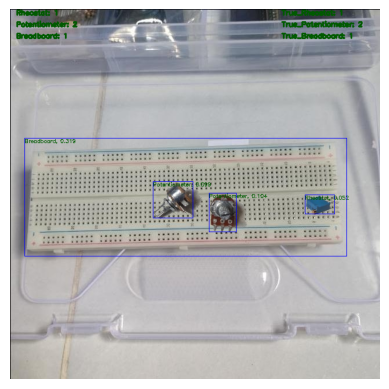

In [34]:
plt.axis("off")

plt.imshow(img_w_bbox)